In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

In [89]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

# Inspection function
def inspect_df(df, name):
    print(f"--- {name} ---")
    print(df.head())
    print(df.info())
    print(df.isnull().sum())
    print("\n")

inspect_df(train, "Train")
inspect_df(test, "Test")
inspect_df(features, "Features")
inspect_df(stores, "Stores")

--- Train ---
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


--- Test ---
   Store  Dept        Date  IsHoliday
0      1     1  2012-11

In [90]:
# 2. Date Conversion
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# 3. Merge
# Using left join to ensure we keep all train records
df = train.merge(stores, on='Store', how='left').merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')

# Markdown handling
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

# 5. Lags and Rolling Averages
# Ensure sorting before shifting
df = df.sort_values(by=['Store', 'Dept', 'Date'])
df['Lag1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df['Lag2'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
df['Rolling_Mean_4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(window=4).mean())
df['Rolling_Mean_8'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(window=8).mean())

# Feature engineering: Time
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day
df['IsHoliday'] = df['IsHoliday'].astype(int)

# Fill NaNs from shift
df.fillna(0, inplace=True)

# 6. Encoding
df['IsHoliday'] = df['IsHoliday'].astype(int)
df = pd.get_dummies(df, columns=['Type'], prefix='Type')

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Lag2,Rolling_Mean_4,Rolling_Mean_8,Year,Month,Week,Day,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,0,151315,42.31,2.572,0.0,0.0,...,0.00,0.00,0.0,2010,2,5,5,True,False,False
1,1,1,2010-02-12,46039.49,1,151315,38.51,2.548,0.0,0.0,...,0.00,0.00,0.0,2010,2,6,12,True,False,False
2,1,1,2010-02-19,41595.55,0,151315,39.93,2.514,0.0,0.0,...,24924.50,0.00,0.0,2010,2,7,19,True,False,False
3,1,1,2010-02-26,19403.54,0,151315,46.63,2.561,0.0,0.0,...,46039.49,0.00,0.0,2010,2,8,26,True,False,False
4,1,1,2010-03-05,21827.90,0,151315,46.50,2.625,0.0,0.0,...,41595.55,32990.77,0.0,2010,3,9,5,True,False,False


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           421570 non-null  int64         
 1   Dept            421570 non-null  int64         
 2   Date            421570 non-null  datetime64[ns]
 3   Weekly_Sales    421570 non-null  float64       
 4   IsHoliday       421570 non-null  int64         
 5   Size            421570 non-null  int64         
 6   Temperature     421570 non-null  float64       
 7   Fuel_Price      421570 non-null  float64       
 8   MarkDown1       421570 non-null  float64       
 9   MarkDown2       421570 non-null  float64       
 10  MarkDown3       421570 non-null  float64       
 11  MarkDown4       421570 non-null  float64       
 12  MarkDown5       421570 non-null  float64       
 13  CPI             421570 non-null  float64       
 14  Unemployment    421570 non-null  flo

Text(0, 0.5, 'Average Weekly Sales')

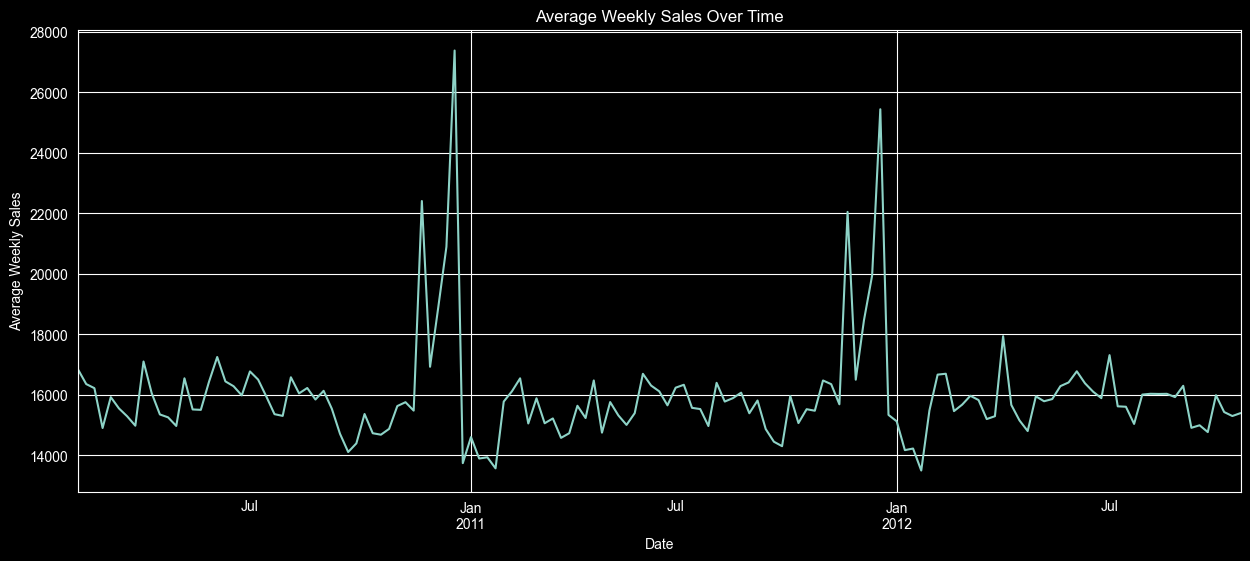

In [92]:
# EDA part 1: Trends over time
plt.figure(figsize=(15, 6))
df.groupby('Date')['Weekly_Sales'].mean().plot()

plt.title('Average Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')

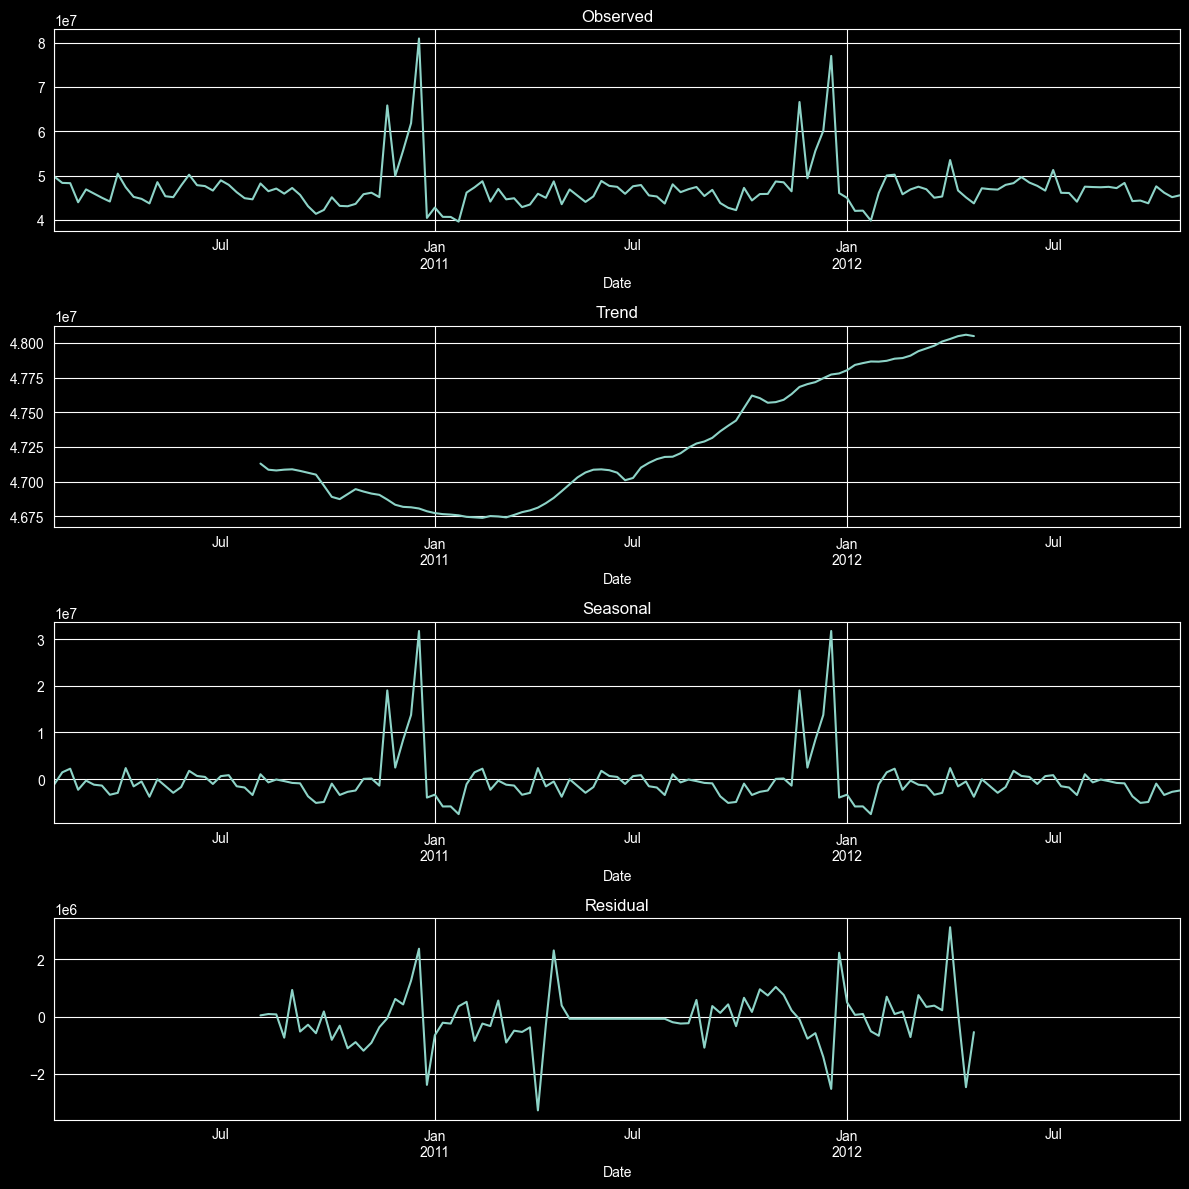

In [93]:
# B. Seasonal Decomposition
ts_data = df.groupby('Date')['Weekly_Sales'].sum()
result = seasonal_decompose(ts_data, model='additive', period=52)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()

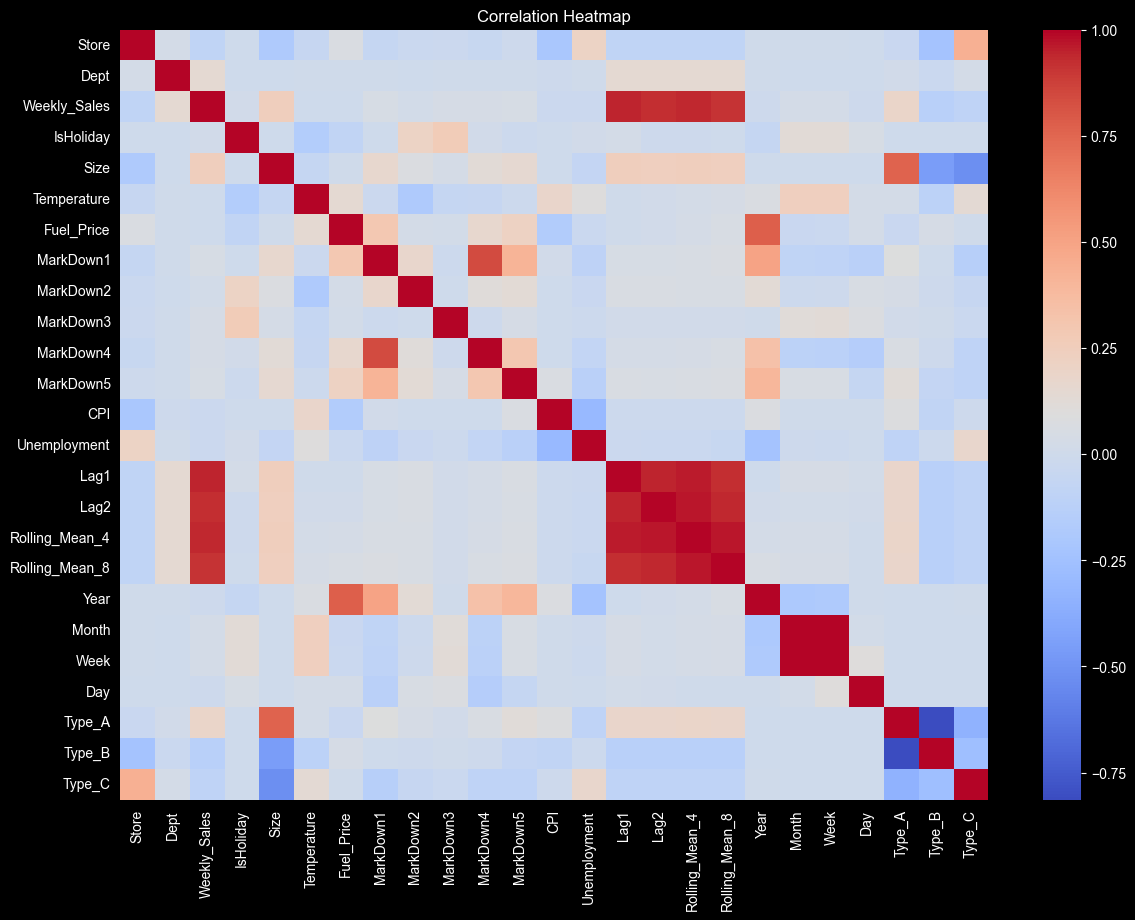

In [94]:
# C. Correlation Matrix
plt.figure(figsize=(14, 10))
corr_matrix = df.drop(columns=['Date']).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_matrix.png')

In [95]:
# 5. Modeling
# Time-aware split: Train up to mid-2012, Val for the rest
split_date = '2012-05-01'
train_set = df[df['Date'] < split_date].copy()
val_set = df[df['Date'] >= split_date].copy()

# Weights for WMAE: 5 if holiday, 1 otherwise
train_weights = train_set['IsHoliday'].apply(lambda x: 5 if x else 1)
val_weights = val_set['IsHoliday'].apply(lambda x: 5 if x else 1)

features_list = ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price',
                   'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                   'CPI', 'Unemployment', 'IsHoliday', 'Month', 'Week', 'Day', 'Year',
                   'Lag1', 'Lag2', 'Rolling_Mean_4', 'Rolling_Mean_8']

In [102]:
X_train, y_train = train_set[features_list], train_set['Weekly_Sales']
X_val, y_val = val_set[features_list], val_set['Weekly_Sales']

COMPARING MULTIPLE MODELS WITH TIME-AWARE VALIDATION

📊 Training HistGradientBoostingRegressor...
  ✅ MAE: 1418.32, WMAE: 1501.75

📊 Training XGBoost Regressor...
  ✅ MAE: 1360.15, WMAE: 1454.53


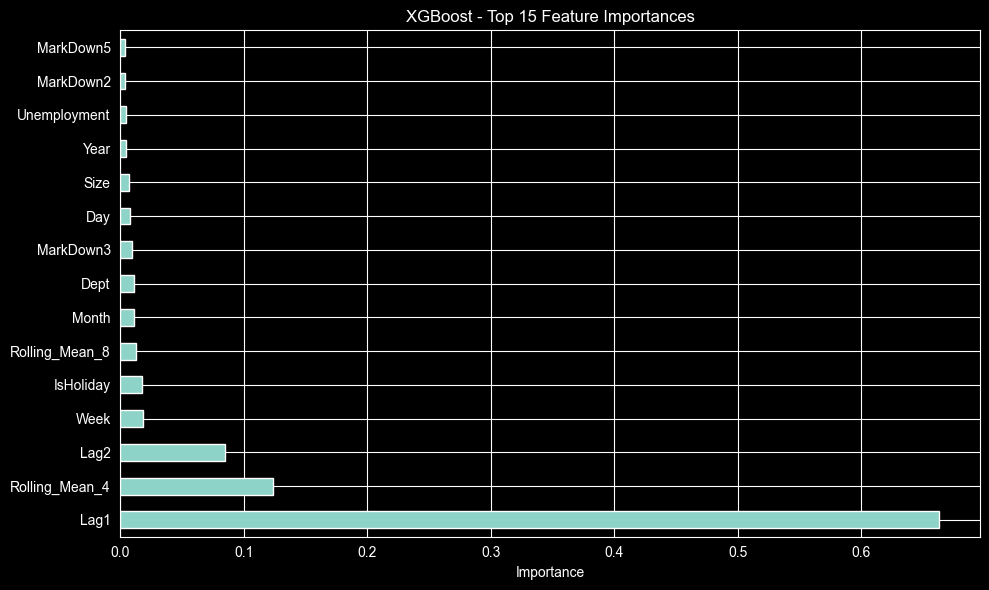


📊 Training LightGBM Regressor...
  ✅ MAE: 1408.95, WMAE: 1484.97


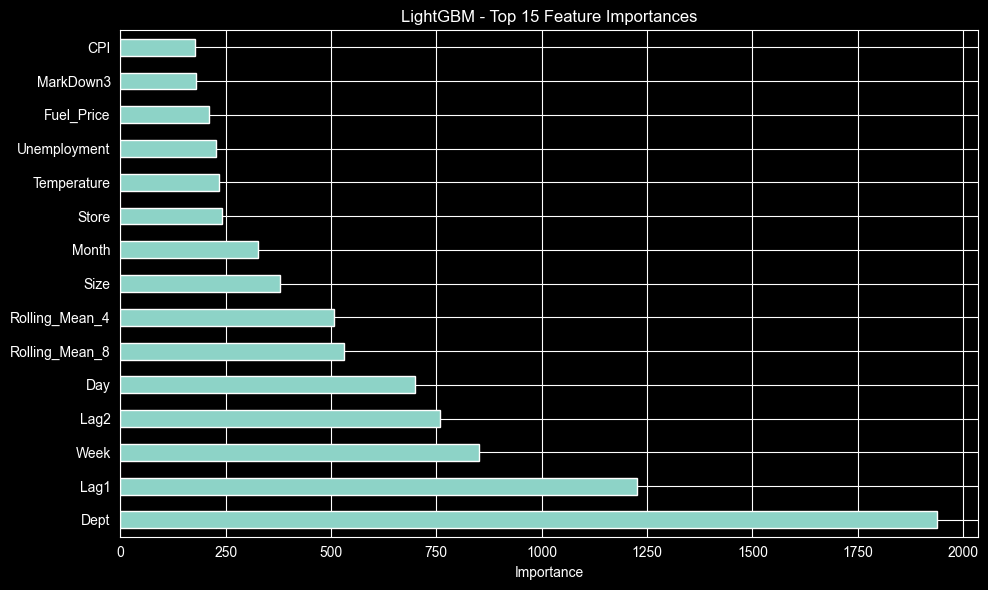


MODEL COMPARISON SUMMARY

📈 Performance Comparison:
                          MAE     WMAE  MAE_Rank  WMAE_Rank  Avg_Rank
XGBoost               1360.15  1454.53       1.0        1.0       1.0
LightGBM              1408.95  1484.97       2.0        2.0       2.0
HistGradientBoosting  1418.32  1501.75       3.0        3.0       3.0

🏆 Best Model: XGBoost with WMAE: 1454.53


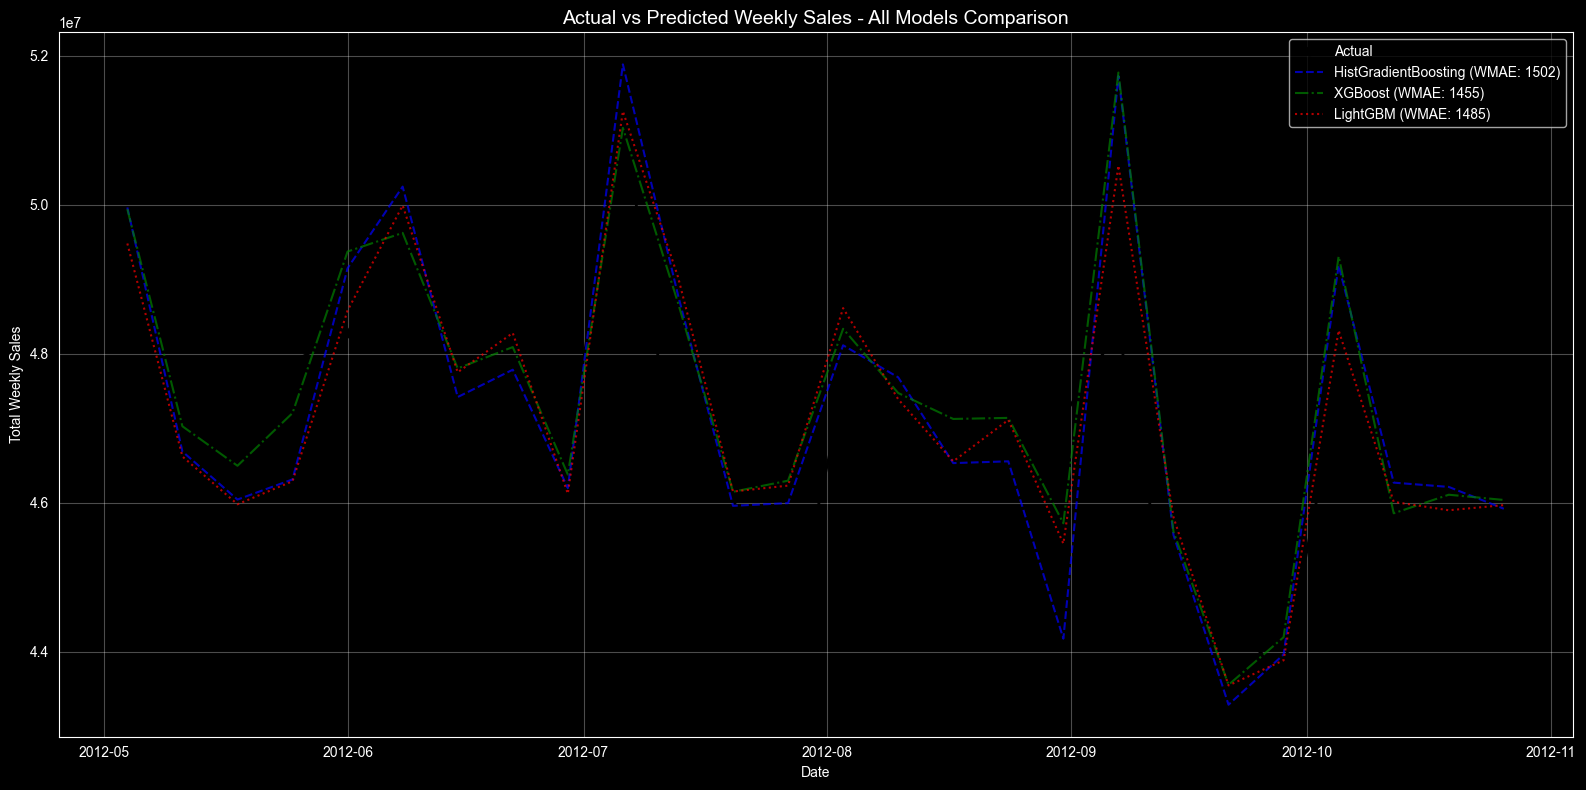

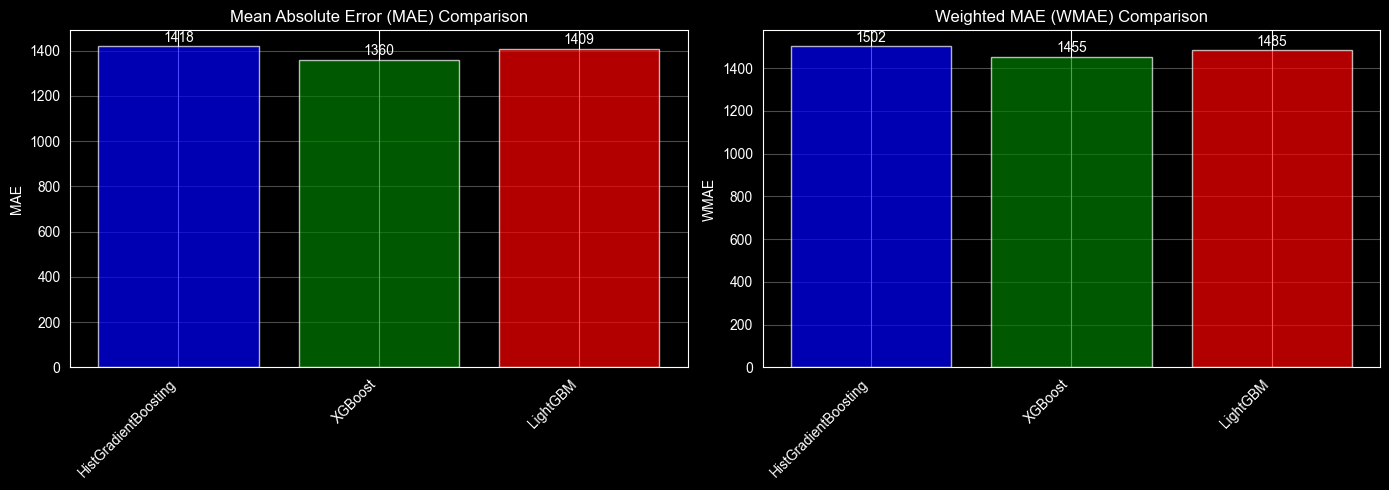

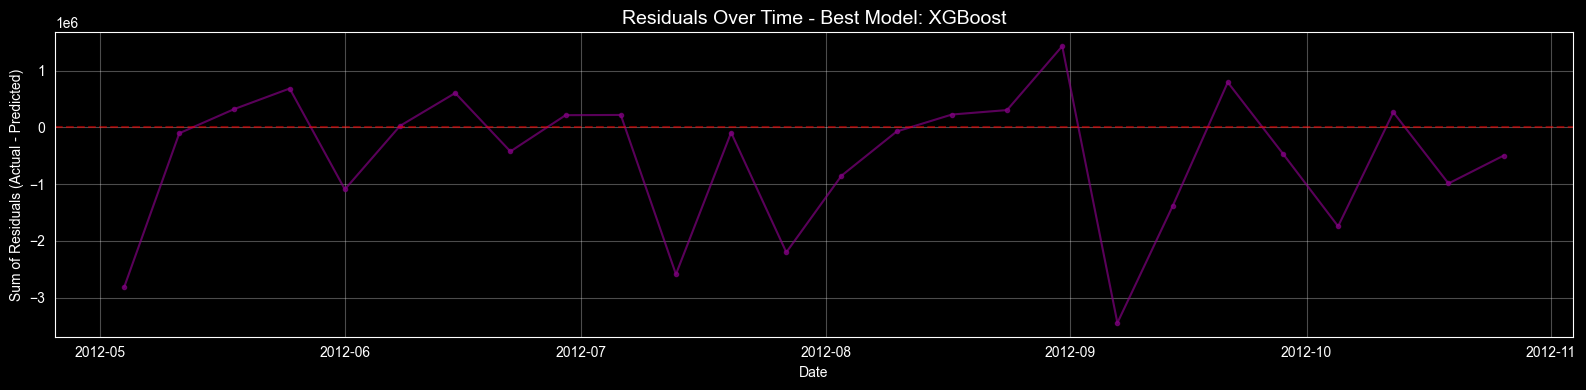


✅ Analysis complete! Best model: XGBoost


In [103]:
# =============================================================================
# 7. MODEL COMPARISON: XGBoost and LightGBM with Time-Aware Validation
# =============================================================================

print("="*60)
print("COMPARING MULTIPLE MODELS WITH TIME-AWARE VALIDATION")
print("="*60)

# Store results for comparison
model_results = {}

# -----------------------------------------------------------------------------
# 7.1 HistGradientBoostingRegressor
# -----------------------------------------------------------------------------
print("\n📊 Training HistGradientBoostingRegressor...")
hgb_model = HistGradientBoostingRegressor(
    max_iter=200,
    max_depth=10,
    random_state=42
)
hgb_model.fit(X_train, y_train)
hgb_preds = hgb_model.predict(X_val)

hgb_mae = mean_absolute_error(y_val, hgb_preds)
hgb_wmae = wmae_calc(y_val, hgb_preds, val_set['IsHoliday'])

model_results['HistGradientBoosting'] = {
    'MAE': hgb_mae,
    'WMAE': hgb_wmae,
    'predictions': hgb_preds,
    'model': hgb_model
}
print(f"  ✅ MAE: {hgb_mae:.2f}, WMAE: {hgb_wmae:.2f}")

# -----------------------------------------------------------------------------
# 7.2 XGBoost Regressor
# -----------------------------------------------------------------------------
print("\n📊 Training XGBoost Regressor...")

# XGBoost parameters (tuned for this problem)
xgb_params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

xgb_preds = xgb_model.predict(X_val)
xgb_mae = mean_absolute_error(y_val, xgb_preds)
xgb_wmae = wmae_calc(y_val, xgb_preds, val_set['IsHoliday'])

model_results['XGBoost'] = {
    'MAE': xgb_mae,
    'WMAE': xgb_wmae,
    'predictions': xgb_preds,
    'model': xgb_model
}
print(f"  ✅ MAE: {xgb_mae:.2f}, WMAE: {xgb_wmae:.2f}")

# Feature importance plot for XGBoost
plt.figure(figsize=(10, 6))
xgb_importance = pd.Series(
    xgb_model.feature_importances_,
    index=features_list
).sort_values(ascending=False)
xgb_importance.head(15).plot(kind='barh')
plt.title('XGBoost - Top 15 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 7.3 LightGBM Regressor
# -----------------------------------------------------------------------------
print("\n📊 Training LightGBM Regressor...")

# LightGBM parameters
lgb_params = {
    'n_estimators': 300,
    'max_depth': 10,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

lgb_preds = lgb_model.predict(X_val)
lgb_mae = mean_absolute_error(y_val, lgb_preds)
lgb_wmae = wmae_calc(y_val, lgb_preds, val_set['IsHoliday'])

model_results['LightGBM'] = {
    'MAE': lgb_mae,
    'WMAE': lgb_wmae,
    'predictions': lgb_preds,
    'model': lgb_model
}
print(f"  ✅ MAE: {lgb_mae:.2f}, WMAE: {lgb_wmae:.2f}")

# Feature importance plot for LightGBM
plt.figure(figsize=(10, 6))
lgb_importance = pd.Series(
    lgb_model.feature_importances_,
    index=features_list
).sort_values(ascending=False)
lgb_importance.head(15).plot(kind='barh')
plt.title('LightGBM - Top 15 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# =============================================================================
# 7.4 MODEL COMPARISON SUMMARY
# =============================================================================
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    model: {
        'MAE': results['MAE'],
        'WMAE': results['WMAE']
    }
    for model, results in model_results.items()
}).T

comparison_df = comparison_df.round(2)
comparison_df['MAE_Rank'] = comparison_df['MAE'].rank()
comparison_df['WMAE_Rank'] = comparison_df['WMAE'].rank()
comparison_df['Avg_Rank'] = (comparison_df['MAE_Rank'] + comparison_df['WMAE_Rank']) / 2

print("\n📈 Performance Comparison:")
print(comparison_df.sort_values('WMAE'))

# Find best model based on WMAE (the competition metric)
best_model_name = min(model_results.keys(), key=lambda x: model_results[x]['WMAE'])
best_model = model_results[best_model_name]['model']
best_preds = model_results[best_model_name]['predictions']

print(f"\n🏆 Best Model: {best_model_name} with WMAE: {model_results[best_model_name]['WMAE']:.2f}")

# =============================================================================
# 7.5 ENHANCED VISUALIZATION: Compare all models
# =============================================================================

# Create comparison dataframe for plotting
val_dates = val_set['Date'].unique()
daily_actual = val_set.groupby('Date')['Weekly_Sales'].sum()

daily_predictions = {}
for model_name, results in model_results.items():
    val_temp = val_set[['Date']].copy()
    val_temp['Pred'] = results['predictions']
    daily_predictions[model_name] = val_temp.groupby('Date')['Pred'].sum()

# Plot 1: All models vs Actual (Time Series)
plt.figure(figsize=(16, 8))
plt.plot(daily_actual.index, daily_actual.values,
         label='Actual', color='black', linewidth=2, marker='o')

colors = {'HistGradientBoosting': 'blue', 'XGBoost': 'green', 'LightGBM': 'red'}
linestyles = {'HistGradientBoosting': '--', 'XGBoost': '-.', 'LightGBM': ':'}

for model_name in model_results.keys():
    plt.plot(daily_predictions[model_name].index,
             daily_predictions[model_name].values,
             label=f'{model_name} (WMAE: {model_results[model_name]["WMAE"]:.0f})',
             color=colors.get(model_name, 'gray'),
             linestyle=linestyles.get(model_name, '-'),
             alpha=0.7)

plt.title('Actual vs Predicted Weekly Sales - All Models Comparison', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Bar chart comparison of errors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = list(model_results.keys())
mae_values = [model_results[m]['MAE'] for m in models]
wmae_values = [model_results[m]['WMAE'] for m in models]
x_pos = range(len(models))

# MAE Comparison
axes[0].bar(x_pos, mae_values, color=['blue', 'green', 'red'], alpha=0.7)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].set_title('Mean Absolute Error (MAE) Comparison')
axes[0].set_ylabel('MAE')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(mae_values):
    axes[0].text(i, v + 20, f'{v:.0f}', ha='center', fontsize=10)

# WMAE Comparison
axes[1].bar(x_pos, wmae_values, color=['blue', 'green', 'red'], alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].set_title('Weighted MAE (WMAE) Comparison')
axes[1].set_ylabel('WMAE')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(wmae_values):
    axes[1].text(i, v + 20, f'{v:.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Plot 3: Residual plot for best model
plt.figure(figsize=(16, 4))
val_temp = val_set[['Date', 'Weekly_Sales']].copy()
val_temp['Prediction'] = best_preds
val_temp['Residual'] = val_temp['Weekly_Sales'] - val_temp['Prediction']
daily_residuals = val_temp.groupby('Date')['Residual'].sum()

plt.plot(daily_residuals.index, daily_residuals.values,
         color='purple', marker='.', linestyle='-', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.title(f'Residuals Over Time - Best Model: {best_model_name}', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sum of Residuals (Actual - Predicted)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Analysis complete! Best model: {best_model_name}")